# **CIFAR 10**
A FFNN (Feed Forward Neural Network) and CNN (Convolutional Nerual Network) have been modeled

## Import required packages

In [1]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt 

## Defining our Transforms


In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

## Gathering the train and test data

In [3]:
train_data=datasets.CIFAR10('data',train=True,download=True,transform=transform_train)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


## Defining our Train, Valid and Test Dataloaders

In [4]:
num_workers=0
batch_size=50
valid_size=0.2
train_length = len(train_data)
indices=list(range(len(train_data)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

train_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=train_sampler)
valid_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=validation_sampler)
test_loader=DataLoader(test_data,shuffle=True,num_workers=num_workers,batch_size=batch_size)

In [5]:
dataiter=iter(train_loader)
images,labels=dataiter.next()
images,labels,images.shape,labels.shape

(tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -0.6549, -1.0000, -1.0000],
           [-1.0000, -0.3490, -0.3490,  ..., -0.9529, -0.6706, -1.0000],
           [-0.3569, -0.8431, -0.8745,  ..., -0.9608, -0.6706, -1.0000],
           ...,
           [-1.0000, -0.0902, -0.1137,  ..., -0.0510, -0.0588,  0.1529],
           [-1.0000, -0.0745, -0.1059,  ...,  0.2157,  0.2235, -1.0000],
           [-1.0000, -1.0000, -0.0510,  ..., -1.0000, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000, -1.0000,  ..., -0.6392, -1.0000, -1.0000],
           [-1.0000, -0.3725, -0.3804,  ..., -0.9608, -0.6627, -1.0000],
           [-0.3882, -0.8745, -0.9059,  ..., -0.9686, -0.6627, -1.0000],
           ...,
           [-1.0000, -0.0902, -0.1216,  ..., -0.1765, -0.1765,  0.0824],
           [-1.0000, -0.0824, -0.1216,  ...,  0.1294,  0.1294, -1.0000],
           [-1.0000, -1.0000, -0.0588,  ..., -1.0000, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000, -1.0000,  ..., -0.6784, -1.0000, -1.0000],
           [-

## Visualizing a Training batch

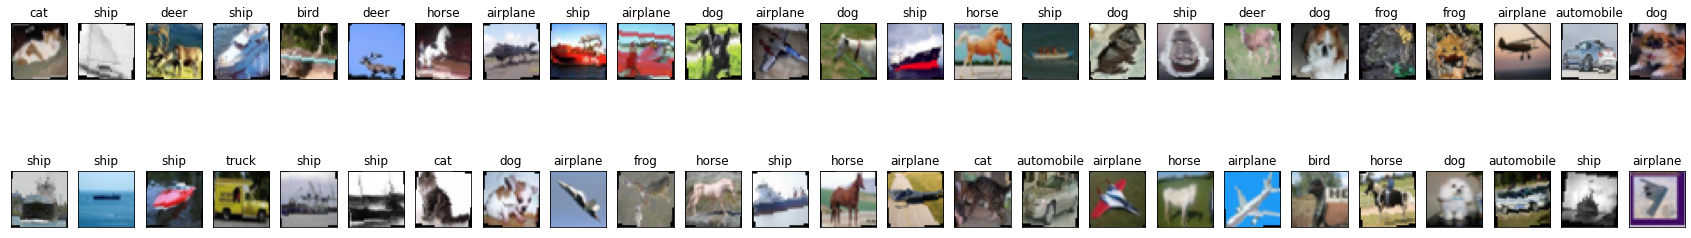

In [6]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,5))
for idx in range(batch_size):
    ax=fig.add_subplot(2,batch_size/2,idx+1,xticks=[],yticks=[])
    RGBshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Defining our Neural Net Architecture

In [52]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(3*32*32,2048)
        self.fc2=nn.Linear(2048,1024)
        self.fc3=nn.Linear(1024,512)
        self.fc4=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        self.dropout=nn.Dropout(0.25)

    def forward(self,x):
        x=x.view(-1,32*32*3)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.dropout(F.relu(self.fc3(x)))
        x=self.dropout(F.relu(self.fc4(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
    def __init__(self):
        super(convNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv5=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.b1=nn.BatchNorm2d(16)
        self.b2=nn.BatchNorm2d(64)
        self.b3=nn.BatchNorm2d(256)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)  

        self.dropout=nn.Dropout(0.1)
        self.fc1=nn.Linear(256,128)
        self.fc2=nn.Linear(128,64)
        self.out=nn.Linear(64,10)


    def forward(self,x):
        x=self.pool(F.relu(self.b1(self.conv1(x))))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.b2(self.conv3(x))))
        x=self.pool(F.relu(self.conv4(x)))
        x=self.pool(F.relu(self.b3(self.conv5(x))))
        x=x.view(-1,256)
        x = self.dropout(x)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)   
        return x



In [53]:
def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model_1=FNet()
model_2=convNet()
model_1.apply(weight_init_normal),model_2.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
    model_1.cuda()
    model_2.cuda()
print(model_1,'\n\n\n\n',model_2,'\n','On GPU : ',use_cuda and torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
) 



 convNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

## Defining our Loss Function

In [54]:
criterion=nn.CrossEntropyLoss()

## Training and Validation Phase

In [55]:
def trainNet(model,lr,trainer,validater):
    optimizer=torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    acc_keeper={'train':[],'valid':[]}
    train_class_correct = list(0. for i in range(10))
    valid_class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    epochs=50

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0
        train_correct=0.0
        valid_correct=0.0
        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in trainer:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
            _, pred = torch.max(output, 1)
            train_correct=np.squeeze(pred.eq(labels.data.view_as(pred)))
            for idx in range(batch_size):
                label = labels[idx]
                train_class_correct[label] += train_correct[idx].item()
                class_total[label] += 1

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in validater:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()
            _, pred = torch.max(output, 1)
            valid_correct=np.squeeze(pred.eq(labels.data.view_as(pred)))
            for idx in range(batch_size):
                label = labels[idx]
                valid_class_correct[label] += valid_correct[idx].item()
                class_total[label] += 1

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(trainer)
        valid_loss = valid_loss/len(validater)

        # Calculating loss over entire batch size for every epoch
        train_acc=float(100. * np.sum(train_class_correct) / np.sum(class_total))
        valid_acc=float(100. * np.sum(valid_class_correct) / np.sum(class_total))

        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        # saving acc values
        acc_keeper['train'].append(train_acc)
        acc_keeper['valid'].append(valid_acc)

        print(f"Epoch : {epoch+1}")
        print(f"Training Loss : {train_loss}\tValidation Loss : {valid_loss}")

        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss

        print(f"Training Accuracy : {train_acc}\tValidation Accuracy : {valid_acc}\n\n")

    return(loss_keeper,acc_keeper)

In [61]:
m1_loss,m1_acc=trainNet(model_1,0.01,train_loader,valid_loader)

Epoch : 1
Training Loss : 1.8184081472456455	Validation Loss : 1.6293590289354325
Validation loss decreased from : inf ----> 1.6293590289354325 ----> Saving Model.......
Training Accuracy : 27.388	Validation Accuracy : 8.306


Epoch : 2
Training Loss : 1.6297422754764557	Validation Loss : 1.5066902017593384
Validation loss decreased from : 1.6293590289354325 ----> 1.5066902017593384 ----> Saving Model.......
Training Accuracy : 30.593	Validation Accuracy : 8.805


Epoch : 3
Training Loss : 1.5533177910745144	Validation Loss : 1.4985917347669602
Validation loss decreased from : 1.5066902017593384 ----> 1.4985917347669602 ----> Saving Model.......
Training Accuracy : 32.333333333333336	Validation Accuracy : 8.956666666666667


Epoch : 4
Training Loss : 1.5009109309315682	Validation Loss : 1.4408713352680207
Validation loss decreased from : 1.4985917347669602 ----> 1.4408713352680207 ----> Saving Model.......
Training Accuracy : 33.6145	Validation Accuracy : 9.171


Epoch : 5
Training Los

In [63]:
m1_loss,m1_acc


({'train': [1.8184081472456455,
   1.6297422754764557,
   1.5533177910745144,
   1.5009109309315682,
   1.4535348777472974,
   1.421860800087452,
   1.3834773079305887,
   1.3584277645498515,
   1.3382479014247657,
   1.3138596402108669,
   1.2887152896821499,
   1.2747987344115972,
   1.2576038641482592,
   1.23643539480865,
   1.2248164308071137,
   1.2087860307097436,
   1.1922735955566168,
   1.180279007330537,
   1.1644388112425803,
   1.1477006555348634,
   1.139000685289502,
   1.12764461055398,
   1.107671964839101,
   1.0993414587527512,
   1.0826029417663812,
   1.0739635211229324,
   1.0596458283811807,
   1.0516263993084431,
   1.0404094330221414,
   1.0322133825719357,
   1.0189089814573526,
   1.0078918331116438,
   0.9947864559292793,
   0.9857012049853802,
   0.9735444796085357,
   0.9690871941298247,
   0.956627284809947,
   0.9495438619703055,
   0.9454470585286617,
   0.9344818510115147,
   0.9207439371943473,
   0.9186410284787416,
   0.9101931774616241,
   0.897860

In [56]:
m2_loss,m2_acc=trainNet(model_2,0.01,train_loader,valid_loader)

Epoch : 1
Training Loss : 1.5427899305522441	Validation Loss : 1.2407439693808555
Validation loss decreased from : inf ----> 1.2407439693808555 ----> Saving Model.......
Training Accuracy : 34.72	Validation Accuracy : 10.866


Epoch : 2
Training Loss : 1.219588153809309	Validation Loss : 1.2029879930615426
Validation loss decreased from : 1.2407439693808555 ----> 1.2029879930615426 ----> Saving Model.......
Training Accuracy : 39.968	Validation Accuracy : 11.213


Epoch : 3
Training Loss : 1.073725524097681	Validation Loss : 0.9998647397756577
Validation loss decreased from : 1.2029879930615426 ----> 0.9998647397756577 ----> Saving Model.......
Training Accuracy : 43.275333333333336	Validation Accuracy : 11.746666666666666


Epoch : 4
Training Loss : 0.9800041484460235	Validation Loss : 0.9572411614656449
Validation loss decreased from : 0.9998647397756577 ----> 0.9572411614656449 ----> Saving Model.......
Training Accuracy : 45.687	Validation Accuracy : 12.1305


Epoch : 5
Training Lo

In [57]:
m2_loss,m2_acc


({'train': [1.5427899305522441,
   1.219588153809309,
   1.073725524097681,
   0.9800041484460235,
   0.9123231897875667,
   0.858500635959208,
   0.8169599203765392,
   0.7759657819196581,
   0.7459815958887339,
   0.7201888270303607,
   0.6951084020361304,
   0.6675753006152809,
   0.6489994798228145,
   0.6360651222988963,
   0.6202756110206247,
   0.5987256365641952,
   0.5793298280611634,
   0.5672721949033439,
   0.5544207569956779,
   0.5473330308310688,
   0.5295237194001675,
   0.5170003197155892,
   0.5087485767155886,
   0.4964491568878293,
   0.4875553767941892,
   0.47679900577291845,
   0.4659781336504966,
   0.4625295162014663,
   0.4498046372830868,
   0.4383863798715174,
   0.4307455290760845,
   0.4257961021736264,
   0.4171432566083968,
   0.41096849656663836,
   0.40116079582832753,
   0.3900477355718613,
   0.38918954259715977,
   0.38199772154912354,
   0.37096670937724413,
   0.368423920115456,
   0.36462728868238625,
   0.3578193570114672,
   0.3485513342451304,

## Loading model from Lowest Validation Loss

In [64]:
# Loading the model from the lowest validation loss 
model_1.load_state_dict(torch.load('FNet_model.pth'))
model_2.load_state_dict(torch.load('convNet_model.pth'))


<All keys matched successfully>

In [65]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Plotting Training and Validation Losses

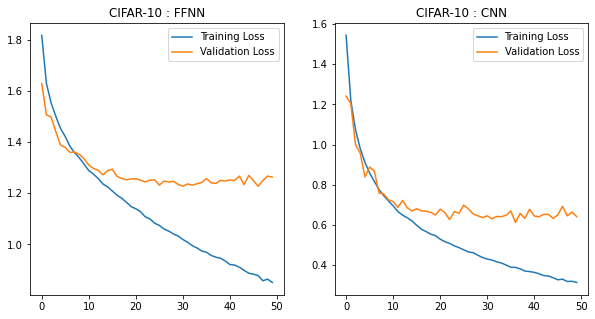

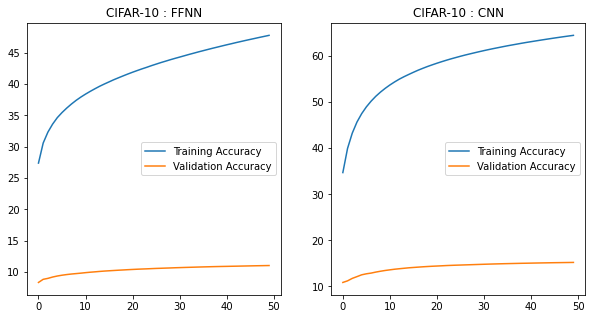

In [69]:
title=['FFNN','CNN']
model_losses=[m1_loss,m2_loss]
model_accs=[m1_acc,m2_acc]

fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('CIFAR-10 : '+title[idx-1])
  idx+=1
  plt.legend();

fig=plt.figure(2,figsize=(10,5))
idx=1
for i in model_accs:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Accuracy")
  ax.plot(i['valid'],label="Validation Accuracy")
  ax.set_title('CIFAR-10 : '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [70]:
def test(model):
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for idx in range(batch_size):
            label = labels[idx]
            class_correct[label] += correct[idx].item()
            class_total[label] += 1


    test_loss=test_loss/len(test_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {classes[i]} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 15))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(5, batch_size/5, idx+1, xticks=[], yticks=[])
        RGBshow(np.squeeze(images[idx]))
        ax.set_title("{}({}) for {}({})".format(classes[preds[idx]],str(preds[idx].item()), classes[labels[idx]],str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

## Visualizing a Test batch with results

### FFNN

For FNet :
Test Loss: 1.2484289520978928
Correctly predicted per class : [669.0, 632.0, 399.0, 317.0, 495.0, 560.0, 695.0, 632.0, 711.0, 682.0], Total correctly perdicted : 5792.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class airplane : 66.9% where 669 of 1000 were predicted correctly
Test Accuracy of class automobile : 63.2% where 632 of 1000 were predicted correctly
Test Accuracy of class bird : 39.9% where 399 of 1000 were predicted correctly
Test Accuracy of class cat : 31.7% where 317 of 1000 were predicted correctly
Test Accuracy of class deer : 49.5% where 495 of 1000 were predicted correctly
Test Accuracy of class dog : 56.0% where 560 of 1000 were predicted correctly
Test Accuracy of class frog : 69.5% where 695 of 1000 were predicted correctly
Test Accuracy of class horse : 63.2% where 632 of 1000 were predicted correctly
Test Accuracy of class ship

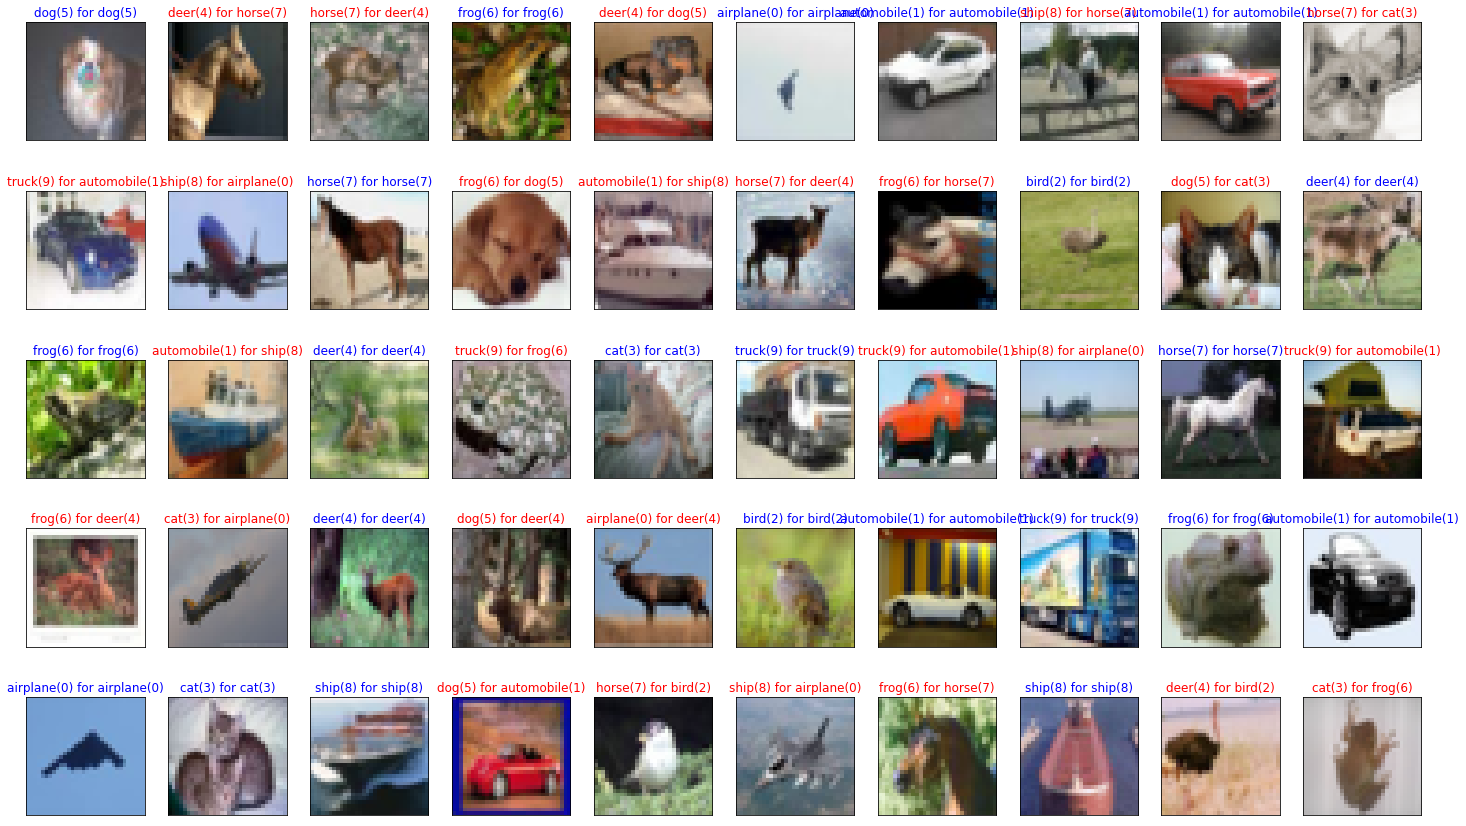

In [71]:
test(model_1)

### CNN

For convNet :
Test Loss: 0.5986490300297738
Correctly predicted per class : [883.0, 918.0, 735.0, 650.0, 822.0, 641.0, 848.0, 835.0, 888.0, 866.0], Total correctly perdicted : 8086.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class airplane : 88.3% where 883 of 1000 were predicted correctly
Test Accuracy of class automobile : 91.8% where 918 of 1000 were predicted correctly
Test Accuracy of class bird : 73.5% where 735 of 1000 were predicted correctly
Test Accuracy of class cat : 65.0% where 650 of 1000 were predicted correctly
Test Accuracy of class deer : 82.2% where 822 of 1000 were predicted correctly
Test Accuracy of class dog : 64.1% where 641 of 1000 were predicted correctly
Test Accuracy of class frog : 84.8% where 848 of 1000 were predicted correctly
Test Accuracy of class horse : 83.5% where 835 of 1000 were predicted correctly
Test Accuracy of class s

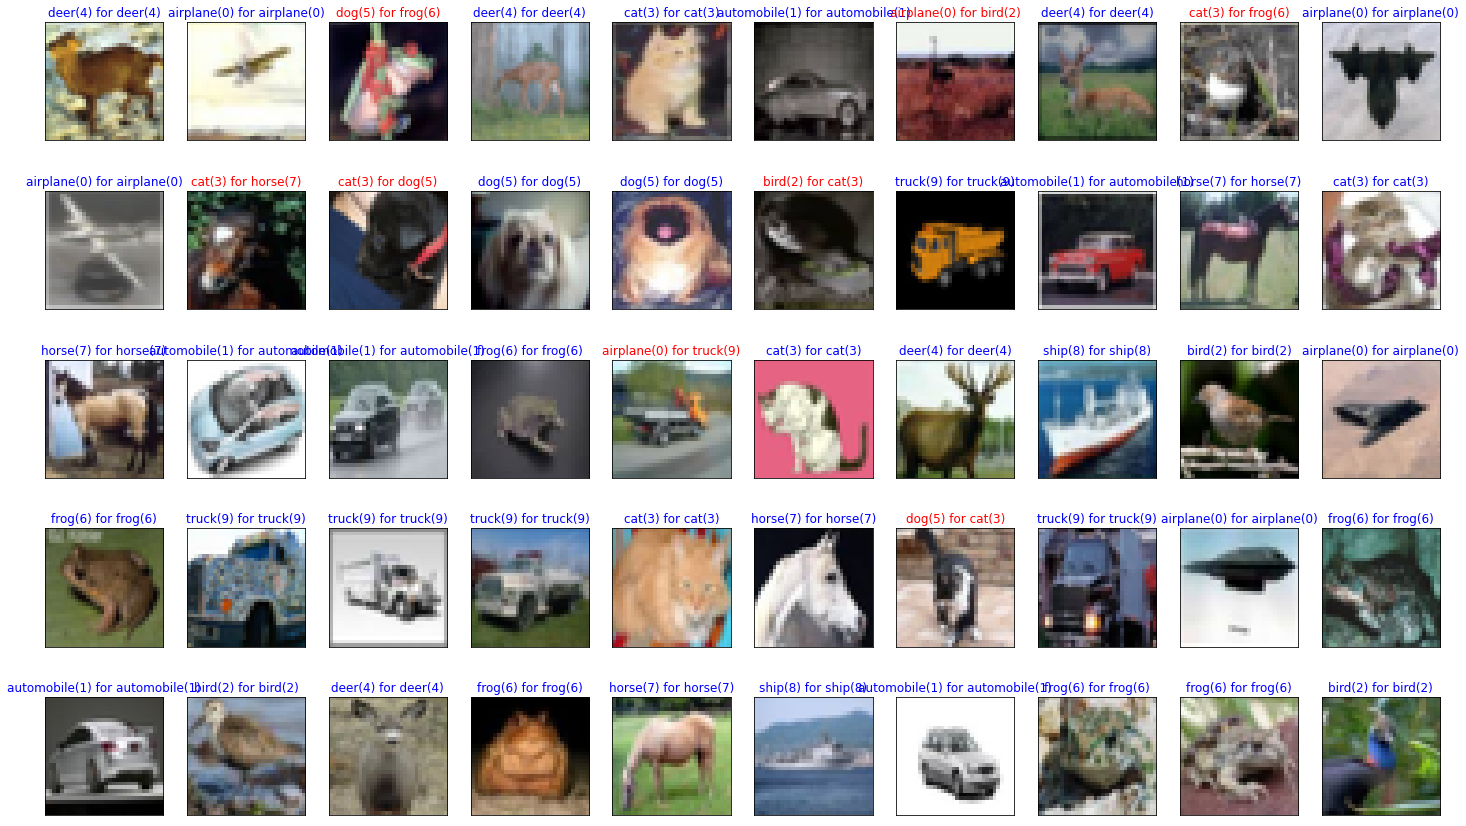

In [72]:
test(model_2)
